In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from datetime import timedelta

#Read CSV
df = pd.read_csv('Week 3 data several days.csv')
df['DateTime'] = df['Date'] + ' ' + df['Time']

df

,Date,Time,lights,s2,DateTime
0,10-Jun-17,12:25:00,1,3,10-Jun-17 12:25:00
1,10-Jun-17,12:26:00,1,3,10-Jun-17 12:26:00
2,10-Jun-17,12:27:00,1,1,10-Jun-17 12:27:00
3,10-Jun-17,12:28:00,1,5,10-Jun-17 12:28:00
4,10-Jun-17,12:29:00,1,0,10-Jun-17 12:29:00
...,...,...,...,...,...
25999,28-Jun-17,13:44:00,0,0,28-Jun-17 13:44:00
26000,28-Jun-17,13:45:00,0,0,28-Jun-17 13:45:00
26001,28-Jun-17,13:46:00,0,0,28-Jun-17 13:46:00
26002,28-Jun-17,13:47:00,0,0,28-Jun-17 13:47:00


In [16]:
#Define Necessary Functions

#For dropping any days not in ld
all_complete_days = df['Date'].unique()

def create_ld(df, all_complete_days):
    bracket = []
    #loop through days and create a new dataframe for each day
    for x in range(len(all_complete_days)):
        bracket.append(df[df.Date==str(all_complete_days[x])])
        
    #drop days that are in dd
    for i in bracket:
        for x in i['Date']:
            lights = (i['lights'].value_counts()[0] == len(i.index))
            if lights == True:
                df.drop(df[df['Date'] == x].index, inplace = True)
                
#For flattening a list of lists:
def flatten_list(list1):
    flat_list = []
    
    # Iterate through the outer list
    for element in list1:
        if type(element) is list:
            
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

#for adding minutes to a dataframe:
def add_minutes(df):
    
    #Create nested list containing the total number of minutes in each day with the length of the number of days
    total_minutes = []
    minutes = np.arange(1,1441).tolist()
    num_days = len(pd.unique(df['Date']).tolist())
    total_minutes.extend([minutes for i in range(num_days)])
    
    #create new list with the total number of minutes in a day multiplied by the number of full days
    total_minutes_list = flatten_list(total_minutes)
    
    #append the flattened list to the original dataframe
    df['Total Minutes'] = total_minutes_list

#for dropping incomplete days
def drop_incomplete(df):
    minutes_in_day = 24*60
    all_days = df.Date.unique()
    #loop through minutes in day, drop the date from original dataframe when the number of values for that day doesnt equal minute in day
    for i in all_days:
        minutes = (sum(df.Date == i) == minutes_in_day)
        if minutes == False:
            df.drop(df[df['Date'] == i].index, inplace = True)

#for adding rolling average to dataframe
def add_rolling(df):
    #calculate rolling average of dataframe
    activ = df.s2
    rolling = activ.rolling(30).mean().dropna()

    #Add new column to dataframe with the rolling mean
    df['Rolling'] = rolling
    
def add_rolling_big(df):
    #calculate rolling average of dataframe
    activ = df.iloc[: , 0]
    rolling = activ.rolling(30).mean().dropna()

    #Add new column to dataframe with the rolling mean
    df['Rolling'] = rolling

#for calculting activity onset of every day in dataframe, make this a new dataframe
def calculate_activity_onset(df):
    #create empty lists and dataframe with dates and empty activity onset column
    all_days = df.Date.unique()
    bracket1 = []
    activity_onset_values = []
    column_names = ['Date', 'Activity Onset']
    activity_onset = pd.DataFrame(columns = column_names)
    activity_onset['Date'] = all_days
    
    #loop through dates and create new dataframe for each day
    for x in range(len(all_days)):
        bracket1.append(df[df.Date==str(all_days[x])])
    
    for i in bracket1:
        #calculate treshold
        stdv = i.Rolling.std()
        threshold = i.Rolling.mean() + stdv
    
        #determine where threshold is crossed
        threshold_crossings = np.diff(i.Rolling > threshold, prepend=False)

        #create a new array with index of threshold crossings for each day
        threshold_crossings_array = np.argwhere(threshold_crossings)[::2,0]

        #find the first threshold crossing after minute 1142, as this is considered the activity onset for the day
        true_threshold_crossings_array = threshold_crossings_array[threshold_crossings_array >1142]
        
        #append first threshold crossing to list every day
        #activity_onset_values.append(true_threshold_crossings_array[0])
        if len(true_threshold_crossings_array) > 0:
            activity_onset_values.append(true_threshold_crossings_array[0])
            
        #else:
         
    #make threshold crossing list the new dataframe column, set new index
    lights_off = 1142
    activity_onset_values_subtracted = [x - lights_off for x in activity_onset_values]
    activity_onset['Activity Onset'] = activity_onset_values_subtracted
    activity_onset = activity_onset.set_index('Date')
    #activity_onset.to_csv('Activity_onset.csv')
    display(activity_onset)

#Creating raster plot
all_days = df.Date.unique()
def raster_plot(df):
    days= pd.unique(df['Date']).tolist()
    place= 1
    
    bracket = []
    for x in range(len(all_days)):
        bracket.append(df[df.Date==str(all_days[x])])
        
    plt.figure(figsize= (10, 13))
    plt.subplots_adjust(hspace = .2, wspace = 0)
    for i in bracket: 
        plt.subplot(len(all_days), 1, place)
        plt.plot(i['Total Minutes'], i['Rolling'])
        plt.ylabel(all_days[place - 1], rotation=0, labelpad=25)
        if place <= 1: 
            plt.title('Raster Plot of Spider Activity Over Multiple Days')
        else: 
            plt.title('')
            
        plt.yticks([0,15])
        place += 1
        for value in range(len(bracket)): 
            if place >= (len(all_days)+1): 
                plt.xlabel('Minutes Since Start of Day')
                plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
            else: 
                plt.xlabel('')
                plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.axvspan(0, 421, alpha = 0.5, color = 'grey')
        plt.axvspan(1142, 1440, alpha = 0.5, color = 'grey')
        
        #calculate the threshold for the specific day
        calculate = i.loc[i['Total Minutes'] > 421]
        stdv = calculate.Rolling.std()
        threshold = calculate.Rolling.mean() + stdv

        #determine where threshold is crossed
        threshold_crossings = np.diff(i.Rolling > threshold, prepend=False)
        threshold_crossings_array = np.argwhere(threshold_crossings)[::2,0]

        #find the first threshold crossing after minute 1142, as this is considered the activity onset for the day
        true_threshold_crossings_array = threshold_crossings_array[threshold_crossings_array >1000]
        start_shade = true_threshold_crossings_array[0]
        plt.axvline(x = start_shade, color = "red", linestyle = '--', label = "mean activity onset")

In [17]:
# Extracting incomplete experimental days 
create_ld(df, all_complete_days)

#Drop incomplete days
drop_incomplete(df)

#Add minutes to each column
add_minutes(df)

#add rolling average
add_rolling(df)

In [18]:
#display activity onset times dataframe
calculate_activity_onset(df)

,Activity Onset
Date,
11-Jun-17,102
12-Jun-17,100
13-Jun-17,95
14-Jun-17,117
15-Jun-17,117
16-Jun-17,113
17-Jun-17,120
18-Jun-17,116


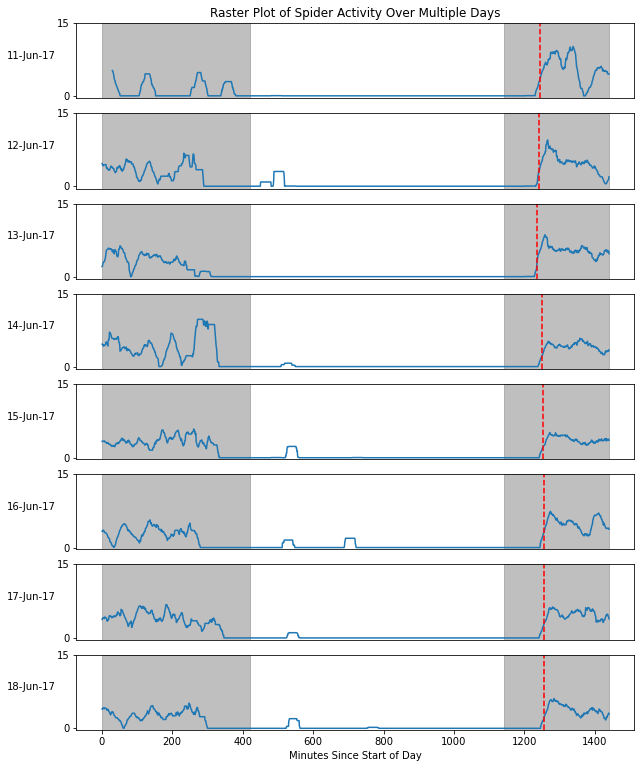

In [8]:
#visualize to verify the calculations
raster_plot(df)

In [19]:
#Read CSV
df1 = pd.read_csv('multiple spiders.csv')

#Create LD dataframe
all_complete_days1 = df1['Date'].unique()
create_ld(df1, all_complete_days1)

#Drop incomplete days
drop_incomplete(df1)

#Add minutes
add_minutes(df1)



display(df1)

,Date,Time,lights,s1,s2,s3,s4,s5,s6,s7,...,s24,s25,s26,s27,s28,s29,s30,s31,s32,Total Minutes
695,11-Jun-17,0:00:00,0,6,2,0,0,0,0,7,...,1,0,0,0,0,0,7,6,0,1
696,11-Jun-17,0:01:00,0,0,6,0,0,0,0,8,...,7,0,4,0,0,0,0,0,0,2
697,11-Jun-17,0:02:00,0,0,11,0,0,0,0,0,...,0,0,17,0,0,0,0,1,0,3
698,11-Jun-17,0:03:00,0,0,7,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,4
699,11-Jun-17,0:04:00,0,0,20,0,0,0,5,4,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12210,18-Jun-17,23:55:00,0,0,14,0,0,0,37,0,...,1,0,0,0,0,0,0,16,0,1436
12211,18-Jun-17,23:56:00,0,0,2,0,0,0,13,0,...,2,0,0,0,0,0,0,8,8,1437
12212,18-Jun-17,23:57:00,0,0,6,0,0,0,7,0,...,3,0,0,0,0,0,0,0,4,1438
12213,18-Jun-17,23:58:00,0,0,5,0,0,0,22,0,...,5,0,0,0,0,0,0,0,0,1439


In [20]:
#def add_rolling_multiple_spiders(df):
column_names = list(df1)
all_days = df1.Date.unique()
all_spiders = column_names[3:-1]
all_spider_numbers = []
bracket2 = []
list_of_dates = df1.Date.to_list()





In [21]:
for i in all_spiders:
    bracket2.append(df1[i])
for x in bracket2:
    x = x.to_frame()
    x['Date'] = list_of_dates
    add_minutes(x)
    add_rolling_big(x)
    calculate_activity_onset(x)

,Activity Onset
Date,
11-Jun-17,101
12-Jun-17,97
13-Jun-17,146
14-Jun-17,143
15-Jun-17,129
16-Jun-17,103
17-Jun-17,98
18-Jun-17,95


,Activity Onset
Date,
11-Jun-17,102
12-Jun-17,100
13-Jun-17,95
14-Jun-17,117
15-Jun-17,117
16-Jun-17,113
17-Jun-17,120
18-Jun-17,116


,Activity Onset
Date,
11-Jun-17,117
12-Jun-17,191
13-Jun-17,108
14-Jun-17,113
15-Jun-17,116
16-Jun-17,140
17-Jun-17,95
18-Jun-17,132


,Activity Onset
Date,
11-Jun-17,111
12-Jun-17,113
13-Jun-17,104
14-Jun-17,102
15-Jun-17,108
16-Jun-17,95
17-Jun-17,92
18-Jun-17,93


,Activity Onset
Date,
11-Jun-17,32
12-Jun-17,6
13-Jun-17,131
14-Jun-17,92
15-Jun-17,120
16-Jun-17,164
17-Jun-17,162
18-Jun-17,152


,Activity Onset
Date,
11-Jun-17,100
12-Jun-17,121
13-Jun-17,85
14-Jun-17,103
15-Jun-17,92
16-Jun-17,99
17-Jun-17,115
18-Jun-17,95


,Activity Onset
Date,
11-Jun-17,98
12-Jun-17,92
13-Jun-17,106
14-Jun-17,101
15-Jun-17,109
16-Jun-17,117
17-Jun-17,108
18-Jun-17,113


,Activity Onset
Date,
11-Jun-17,90
12-Jun-17,119
13-Jun-17,126
14-Jun-17,123
15-Jun-17,109
16-Jun-17,128
17-Jun-17,114
18-Jun-17,137


,Activity Onset
Date,
11-Jun-17,27
12-Jun-17,86
13-Jun-17,103
14-Jun-17,97
15-Jun-17,124
16-Jun-17,83
17-Jun-17,40
18-Jun-17,127


,Activity Onset
Date,
11-Jun-17,94
12-Jun-17,88
13-Jun-17,86
14-Jun-17,84
15-Jun-17,84
16-Jun-17,72
17-Jun-17,94
18-Jun-17,90


ValueError: Length of values (2) does not match length of index (8)